<table>
    <tr style="background-color:white;">
        <td width="60%">
            <div style="height: 25px;"></div>
            <div align="left" style="color: #4b324e; font-size: 40px; font-weight: bold;">Taller de Qiskit</div>
        </td>
        <td>
            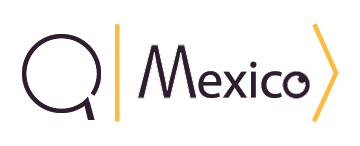
        </td>
    </tr>
</table>

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $

<div align="center" style="color: #EE2A6F; font-size: 30px; font-weight: bold;"> Introducción a Qiskit Nature </div>

<div align="right" style="font-size: 15px; font-weight: normal;">Preparado por Bruno Ramírez</div>

<a href="https://opensource.org/licenses/Apache-2.0"></a>

# Contenido

1. [Introducción](#intro)
2. [El problema de estructura electrónica](#secc1)
   1. [Importancia del problema](#secc1.1)
3. [Primer paso: El método de Hartree-Fock](#secc2)
   1. [Transformación mediante orbitales moleculares](#secc2.1)
   2. [Solucionadores clásicos para los coeficientes del hamiltoniano fermiónico
](#secc2.2)
4. [Segundo paso: Del hamiltoniano molecular al hamiltoniano de qubits](#secc3)
    1. [Mapeos](#secc3.1)     
5. [El problema de estructura electrónica en Qiskit Nature](#secc4)
6. [Mas allá del problema de estructura electrónica](#secc5)
    1. [Caracterizando el estado de mínima energía](#secc5.1)
    

<a id="intro"></a>
# Introducción


Qiskit Nature es el paquete de aplicación de Qiskit dedicado al planteamiento y solución de problemas en química cuántica y estructura electrónica de la materia. Este módulo surgió de forma independiente como parte de las aplicaciones consideradas dentro de `Qiskit Aqua`, el cual fue reemplazado por los diversos modulos de aplicación. 

En su artículo [_Simulating Physics with Computers_](https://www.taylorfrancis.com/chapters/edit/10.1201/9780429500459-11/simulating-physics-computers-richard-feynman), Richard Feynman argumentó que es difícil y poco eficiente simular sistemas cuánticos mediante el cómputo clásico. La forma apropiada de estudiar y modelar sistemas cuánticos es utilizando cómputo cuántico. Qiskit Nature es un paso hacia esta forma de trabajo, aplicando el cómputo cuántico al estudio de sistemas cuya naturaleza es también cuántica. 

Este módulo de aplicación trabaja de forma integrada con otras herramientas de cómputo clásico dedicado a cálculos de estructura electrónica y química cuántica como lo son: `Gaussian`, `PySCF`, `PyQuante`, entre otros. 

La integración clásica-cuántica que provee Qiskit Nature permite resolver problemas como los siguientes:

- [El problema de estructura electrónica molecular](https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html)
- [El problema de estructura vibracional molecular](https://qiskit.org/documentation/nature/tutorials/02_vibrational_structure.html)
- [Cálculo de la energía del estado base de una molécula](https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html)
- [Cálculo de la energía de los estados excitados de una molécula](https://qiskit.org/documentation/nature/tutorials/04_excited_states_solvers.html)
- [Muestreo de la superficie de energía potencial de una molécula](https://qiskit.org/documentation/nature/tutorials/05_Sampling_potential_energy_surfaces.html)
- [Cálculo de observables termodinámicas](https://qiskit.org/documentation/nature/tutorials/06_calculating_thermodynamic_observables.html)

En este notebook trataremos con el primero de estos problemas, el problema de estructura electrónica molecular, con el propósito de presentar los bloques fundamentales en el funcionamiento de Qiskit Nature. Este problema se trata de llevar un hamiltoniano molecular a una forma particular que puede ser implementada en un circuito cuántico. También se discutirá brevemente cómo la solución del problema de estructura electrónica es fundamental para la solución de otros problemas haciendo uso de Qiskit Nature.  

<div class="alert alert-block alert-success">

**Importante**

Dado que Qiskit Nature trabaja de manera integrada con otras herramientas de química cuántica mediante cómputo clásico, te recomiendo verificar la instalación de almenos una de las herramientas complementarias. En este notebook se  utilizará PySCF, herramienta que puede ser instalada ejecutando el comando `pip install PySCF` en la terminal.

</div>


<div class="alert alert-block alert-danger">

**Cuidado**
    
El driver `PySCF` __no funciona en Windows__ dado lo anterior, pedimos que si tienes dicho sistema operativo, ejecutes este notebook en Google Colab o en la IBM Quantum Experience.
    
</div>


Cabe destacar que Qiskit Nature es un paquete dedicado a las áreas de estructura de la materia y química cuántica. Estas son áreas de investigación muy activas desde hace varios años, y por lo mismo tienen una teoría muy amplia y especializada. En este trabajo se hará referencia a conceptos provenientes de estas áreas como lo son la aproximación de Born-Oppenheimer, el método de Hartree-Fock, orbitales moleculares, entre otros. A quien esté interesado en los detalles de la teoría le recomiendo hacer click en los enlaces en el texto y/o revisar el siguiente libro de texto:
    
- Szabo, A., & Ostlund, N. S. (2012). Modern quantum chemistry: introduction to advanced electronic structure theory. Courier Corporation.




In [1]:
# Herramientas de Python auxiliares a Qiskit
import numpy as np
import matplotlib.pyplot as plt

# Herramientas de Qiskit necesarias para crear e importar modelos de ruido
import qiskit

# Herramientas de Qiskit Nature que utilizaremos
from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper


<a id="secc1"></a>
# El problema de la estructura electrónica

De forma amplia, problema de estructura electrónica consiste en el estudio de los estados cuánticos que describen la estructura electrónica de una molécula, en lenguaje matemático esto se refiere a la obtención de soluciones a la ecuación de Schrödinger

$$
\mathcal{H} |\Psi_{n}\rangle = E_{n} |\Psi_{n}\rangle
$$ 

Es de particular interés conocer las energías de los estados base y excitados de una molécula, pues estos valores juegan un papel importante en la [reactividad](https://es.wikipedia.org/wiki/Reactividad) de compuestos químicos y determinan otras caraterícsticas importantes, como su [potencial de oxidación](http://hyperphysics.phy-astr.gsu.edu/hbasees/Chemical/redoxp.html).

Como sucede en todo problema de mecánica cuántica, el primer paso para solucionar la ecuación de Schrödinger es conocer a detalle el operador hamiltoniano que describe a nuestro sistema. En el caso de una molécula, el llamado [hamiltoniano molecular](https://en.wikipedia.org/wiki/Molecular_Hamiltonian) contiene una gran variedad de términos correspondientes a las energías cinéticas y potenciales de todos los componentes de la molécula. Para una con $N$ núcleos e $i$ electrones, el hamiltoniano molecular es el siguiente:

$$
\mathcal{H} = - \sum_N \frac{\nabla_{R_I}^2}{M_N} - \sum_i \frac{\nabla_{r_i}^2}{m_e} - \sum_N\sum_i  \frac{Z_N e^2}{|R_N-r_i|} + \sum_i \sum_{j>i} \frac{e^2}{|r_i-r_j|} + \sum_N\sum_{M>N} \frac{Z_N Z_M e^2}{|R_N-R_M|}
$$

Antes de dejarnos impresionar por la complicada apariencia de este hamiltoniano, es conveniente decir que existen múlitples aproximaciones y cambios de sistema de referencia que nos permitirán simplificar el hamiltoniano molecular. La primera aproximación, la famosa [Aproximación de Born-Oppenheimer](https://en.wikipedia.org/wiki/Born%E2%80%93Oppenheimer_approximation) asume la separabilidad de los grados de libertad electrónicos y nucleares. Dada la aproximación (BO), es común que se considere una versión simplificada del hamiltoniano molecular donde sólo sobreviven los términos asociados a los grados de libertad electrónicos, mientras que la energía correspondiente a los núcleos se incluye en una constante (que generalmente suele ser ignorada mediante un desplazamiento de energía). Adelante se muestra la simplificación, conocida como hamiltoniano electrónico.

$$
\mathcal{H}_{\text{el}} = - \sum_i \frac{\nabla_{r_i}^2}{m_e} - \sum_I\sum_i  \frac{Z_I e^2}{|R_I-r_i|} + \sum_i \sum_{j>i} \frac{e^2}{|r_i-r_j|}.
$$

Ahora uno puede preguntarse, ¿en qué momento hará su entrada el cómputo cuántico? El asunto es el siguiente. Si uno puede utilizar un número determinado de qubits para preparar estados cuánticos que representen los estados electrónicos $\ket{\Psi}_n$, y __más importante aún__ transformar el hamiltoniano molecular a una representación que contenga en sí operadores sobre qubits, por ejemplo las compuertas de Pauli, entonces puede usarse una computadora cuántica para calcular de forma eficiente la energía de dicho estado ejecutando el "circuito hamiltoniano" sobre el estado preparado. Querremos hacer los siguentes cambios

$$
\ket{\Psi}_n \rightarrow \ket{\Psi}_{n,qubit}$$

$$
\mathcal{H}_{el} \rightarrow \mathcal{H}_{el,qubit}
$$

En este notebook nos enfocaremos en el segundo de estos cambios importantes, pues los estados generalmente se "adivinan" de forma aleatoria mediante variación de parámetros.

<a id="secc1.1"></a>
## Importancia del problema

La posibilidad de hacer el simple cambio de representación 

$$\mathcal{H}_{el} \rightarrow \mathcal{H}_{el,qubit}$$

abre las puertas a la ventaja del cómputo cuántico, pues es en este momento que se estarán utilizando sistemas cuya naturaleza es intrínisecamente cuántica para hacer cálculos cuánticos. Entre los cálculos que se hacen con este método se encuentran los cálculos de energías de estado base y excitados, entre otros. 

<a id="secc2"></a>
# Primer paso: el método de Hartree-Fock

<a id="secc2.1"></a>
## Transformaciones  mediante orbirtales moleculares

En nuestro camino hacia la obtención de un hamiltoniano de qubits, hay que hacer un paso asistido por el cómputo clásico. Este paso consiste en la transformación del hamiltoniano electrónico $\mathcal{H}$ en términos de los laplacianos y términos de Coulomb hacia un hamiltoniano electrónico en términos de orbitales moleculares y [operadores fermiónicos](http://accaputo.ch/docs/msc-ethz/presentations/hartree-fock-method.pdf). Esto se hace mediante el [método de Hartree-Fock](http://depa.fquim.unam.mx/amyd/archivero/expoHartree-Fock_32480.pdf). En terminos de las soluciones al método de Hartree-Fock, el hamiltoniano electrónico toma la siguiente apariencia

$$
\hat{H}_{elec}=\sum_{pq} h_{pq} \hat{a}^{\dagger}_p \hat{a}_q +
\frac{1}{2} \sum_{pqrs} h_{pqrs}  \hat{a}^{\dagger}_p \hat{a}^{\dagger}_q \hat{a}_r  \hat{a}_s
$$

Este hamiltoniano está expresado en términos de los operadores fermiónicos de [creación](https://es.wikipedia.org/wiki/Operador_escalera) ($\hat{a}_i^{\dagger}$) y de aniquilación ($\hat{a}_j$), que actúan sobre los llamados "estados de Fock". Estos conceptos forman parte del contexto de la [segunda cuantización](https://en.wikipedia.org/wiki/Second_quantization) un formalismo de la mecánica cuántica desarrollado para el tratamiento de problemas de múltiples cuerpos. En la segunda cuantización, los estados de Fock representan la cantidad de partículas en cada orbital independiente.

<a id="secc2.2"></a>
## Solucionadores clásicos para los coeficientes del hamiltoniano fermiónico

En la expresión del hamiltoniano modificado, los coeficientes $h_{pq}, h_{pqrs}$  son cantidades que se calculan a partir de integrales. Afortunadamente se han desarrollado métodos clásicos para el cálculo de estas integrales. Es por lo anterior que Qiskit Nature está integrado con herramientas de cómputo clásico, conocidas como _drivers_, dedicadas al cálculo numérico de estas cantidades según la configuración espacial de una molécula. En este notebook se usará PySCF como driver.

<a id="secc3"></a>
# Segundo paso: Del hamiltoniano fermiónico al hamiltoniano de qubits

Ahora que el hamiltoniano molecular ha sido reescrito en términos de los operadores fermiónicos de aniquilación y creación, sólo falta encontrar una equivalencia, una forma de pasar esto al lenguaje de los qubits, buscamos:

- Una _codificación_ entre los estados de Fock y los estados de $n$ qubits.
- Un _mapeo_ de los operadores fermiónicos a algo en términos de los operadores de spin, $\{I, \sigma_x, \sigma_y, \sigma_z \}$. 

Al establecer la codificación y encontrar este mapeo, habremos transformado nuestro hamiltoniano fermiónico a un hamiltoniano de qubits y nuestro problema de estructura electrónica a un problema de cómputo cuántico.

$$
\hat{H}_{elec}=\sum_{pq} h_{pq} \hat{a}^{\dagger}_p \hat{a}_q +
\frac{1}{2} \sum_{pqrs} h_{pqrs}  \hat{a}^{\dagger}_p \hat{a}^{\dagger}_q \hat{a}_r  \hat{a}_s \Rightarrow \hat{H} = \sum_i c_i \hat{P_i}
$$

Donde $P_i$ es un producto tensorial particular de los operadores $\{I, \sigma_x, \sigma_y, \sigma_z \}$.

<a id="secc3.1"></a>
## Mapeos

Una vez hallado el número de qubits $n$ necesarios para la codificación, se puede establecer una equivalencia para los operadores de creación. Los diferentes mapeos difieren entre sí en los siguientes aspectos:

- Número de qubits necesarios para la simulación
- Número de qubits en los que los nuevos operadores de spin actúan de forma no-trivial.
- La dificultad (en términos de implementación) de las compuertas resultantes de la transformación

Existen tres mapeos soportados en Qiskit, estos son: El mapeo de __Jordan-Wigner__, el mapeo de __Paridad__, y el mapeo de __Bravyi-Kitaev__. Puedes consultar los detalles acerca de las diferencias entre cada mapeo en [este artículo](https://iopscience.iop.org/article/10.1088/1367-2630/aac54f).

A modo de demostración comentamos que el mapeo de Jordan-Wigner mapea un estado de Fock de $N$ orbitales a uno de $n=N$ qubits, y se muestra la equivalencia que este mapeo establece entre los operadores fermiónicos y los operadores de qubits:

$$
\hat{a}_j^\dagger = \bigotimes_{i=1}^{j-1}\hat{\sigma}_i^z\otimes(\hat{\sigma}_j^x+i\hat{\sigma}_j^y)
$$

$$
\hat{a}_j^\dagger = \bigotimes_{i=1}^{j-1}\hat{\sigma}_i^z\otimes(\hat{\sigma}_j^x-i\hat{\sigma}_j^y)
$$


Un mapeo como el anterior permite llevar el hamiltoniano fermiónico a uno en términos de operadores sobre qubits.


<a id="secc4"></a>
# El problema de estructura electrónica en Qiskit Nature

Las clases fundamentales 

- Clase `Molecule`: Toma los parámetros relevantes a la naturaleza de la molécula a estudiar, entre ellos la geometría, carga y multiplicidad de la molécula. Crea un objeto que se utiliza como argumento al momento de llamar a un driver para calcular las integrales relevantes en el hamiltoniano fermiónico.

- Clase `ElectronicStructureProblem`: Utiliza los resultados proporcionados por el _driver_, crea una clase que contiene entre sus métodos una forma de acceder al hamiltoniano fermiónico. Este está mostrado en términos de los operadores de creación (+), aniquilación (-), número (N) e identidad (I) y los coeficientes proporcionados por el driver. También contiene entre los operadores generados, aquellos correspondientes al momento angular, magnetización, entre, otros. Más información [aquí](https://qiskit.org/documentation/nature/stubs/qiskit_nature.problems.second_quantization.ElectronicStructureProblem.second_q_ops.html#qiskit_nature.problems.second_quantization.ElectronicStructureProblem.second_q_ops).

- Clase `QubitConverter`: Toma el hamiltoniano fermiónico y lo convierte a un hamiltoniano de qubits según el mapeo  que se elija. Esto resulta en una combinación de coeficientes (calculados previamente) y cadenas de operadores identidad (I), y compuertas X, Y, Z, representando los operadores de Pauli sobre los respectivos qubits.

El primer paso es especificar la molécula que estudiaremos. En nuestro caso, optamos por el problema más simple y no trivial, la molécula de hidrógeno $H_2$.

In [2]:

# Comenzamos estableciendo la geometría de una molécula de hidrógeno
# con dos átomos separados por una distancia de 0.735Å, carga neutra y multiplicidad 1
molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)


# Acudimos al PySCF como driver que permita calcular los coeficientes del hamiltoniano fermiónico
driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')

In [3]:

# Clase ElectronicStructureProblem toma los parámetros de nuestro driver para 
# crear una instancia del hamiltoniano fermiónico 
es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()
print("El hamiltoniano fermiónico es:\n")
      
print("H = ", second_q_op[0])

El hamiltoniano fermiónico es:

H =    +-+- * (0.18093119978423136+0j)
+ +--+ * (-0.18093119978423142+0j)
+ -++- * (-0.18093119978423142+0j)
+ -+-+ * (0.18093119978423144+0j)
+ IIIN * (-0.4718960072811406+0j)
+ IINI * (-1.2563390730032502+0j)
+ IINN * (0.4836505304710652+0j)
+ INII * (-0.4718960072811406+0j)
+ ININ * (0.6985737227320181+0j)
+ INNI * (0.6645817302552965+0j)
+ NIII * (-1.2563390730032502+0j)
+ NIIN * (0.6645817302552965+0j)
+ NINI * (0.6757101548035165+0j)
+ NNII * (0.4836505304710652+0j)


Este operador corresponde a una suma de operadores que actúan sobre estados de Fock con cuatro orbitales, el primero siendo $\hat{a}^{\dagger}_1\hat{a}_2\hat{a}^{\dagger}_3\hat{a}_4$ con coeficiente $h = 0.18093119978423136$ correspondiente, el segundo $\hat{a}^{\dagger}_1\hat{a}_2\hat{a}_3\hat{a}^{\dagger}_4$ con coeficiente $h = -0.18093119978423142$, etc. 


In [4]:
#Conversión de los operadores +,-,N,I a operadores de spin X,Y,Z,I utilizando el mapeo de Jordan-Wigner

qubit_converter = QubitConverter(mapper=JordanWignerMapper())
qubit_op = qubit_converter.convert(second_q_op[0])

print("El hamiltoniano de qubits utilizando el mapeo de Jordan-Wigner es:\n")

print(qubit_op)

El hamiltoniano de qubits utilizando el mapeo de Jordan-Wigner es:

-0.8105479805373264 * IIII
- 0.22575349222402463 * ZIII
+ 0.17218393261915566 * IZII
+ 0.1209126326177663 * ZZII
- 0.22575349222402466 * IIZI
+ 0.17464343068300453 * ZIZI
+ 0.16614543256382414 * IZZI
+ 0.17218393261915566 * IIIZ
+ 0.16614543256382414 * ZIIZ
+ 0.16892753870087912 * IZIZ
+ 0.1209126326177663 * IIZZ
+ 0.045232799946057854 * XXXX
+ 0.045232799946057854 * YYXX
+ 0.045232799946057854 * XXYY
+ 0.045232799946057854 * YYYY


In [5]:
#Conversión de los operadores +,-,N,I a operadores de spin X,Y,Z,I utilizando el mapeo de Paridad

qubit_converter = QubitConverter(mapper = ParityMapper()) 
qubit_op = qubit_converter.convert(second_q_op[0])

print("El hamiltoniano de qubits utilizando el mapeo de Paridad es:\n")

print(qubit_op)

El hamiltoniano de qubits utilizando el mapeo de Paridad es:

-0.8105479805373264 * IIII
- 0.22575349222402463 * ZZII
+ 0.1209126326177663 * IIZI
+ 0.1209126326177663 * ZIZI
+ 0.17218393261915566 * IZZI
+ 0.17218393261915566 * IIIZ
+ 0.16614543256382414 * IZIZ
+ 0.16614543256382414 * ZZIZ
- 0.22575349222402466 * IIZZ
+ 0.16892753870087912 * IZZZ
+ 0.17464343068300453 * ZZZZ
+ 0.045232799946057854 * IXIX
+ 0.045232799946057854 * ZXIX
- 0.045232799946057854 * IXZX
- 0.045232799946057854 * ZXZX


In [6]:
#Conversión de los operadores +,-,N,I a operadores de spin X,Y,Z,I utilizando el mapeo de Bravyi-Kitaev

qubit_converter = QubitConverter(mapper = BravyiKitaevMapper()) 
qubit_op = qubit_converter.convert(second_q_op[0])

print("El hamiltoniano de qubits utilizando el mapeo de Bravyi-Kitaev es:\n")
print(qubit_op)

El hamiltoniano de qubits utilizando el mapeo de Bravyi-Kitaev es:

-0.8105479805373264 * IIII
+ 0.17218393261915566 * IZII
+ 0.1209126326177663 * IIZI
+ 0.1209126326177663 * ZIZI
- 0.22575349222402463 * ZZZI
+ 0.17218393261915566 * IIIZ
+ 0.16892753870087912 * IZIZ
+ 0.17464343068300453 * ZZIZ
- 0.22575349222402466 * IIZZ
+ 0.16614543256382414 * IZZZ
+ 0.16614543256382414 * ZZZZ
+ 0.045232799946057854 * IXIX
+ 0.045232799946057854 * ZXIX
- 0.045232799946057854 * IXZX
- 0.045232799946057854 * ZXZX


Así, hemos resuelto el problema de estructura electrónica al haber pasado de una instancia de una molécula con un hamiltoniano determinado, a una expresión para este hamiltoniano en términos de compuertas sobre un conjunto de qubits. 

<a id="secc5"></a>
# Mas allá del problema de estructura electrónica

Este problema es un paso básico para poder sacar ventaja del cómputo cuántico en la solución de problemas de química cuántica más avanzados. Qiskit Nature proporciona las herramientas necesarias para llevar a cabo algoritmos cuánticos que permiten calcular propiedades físicas importantes. Adelante ilustramos una de las aplicaciones más útiles de haber hecho la transformación del hamiltoniano molecular a un hamiltoniano de qubits.


<a id="secc5.1"></a>
## Caracterizando el estado de mínima energía

Una vez que se ha hecho la transformación del hamiltoniano molecular al hamiltoniano de qubits es posible calcular la energía del estado base mediante un proceso de optimización de parámetros. El cálculo de la energía del estado base mediante la optimización de parámetros para buscar un mínimo local tiene su fundamento en [el método o principio variacional](https://es.abcdef.wiki/wiki/Variational_method_%28quantum_mechanics%29). De forma práctica, el cálculo se hace de la siguiente forma:

1. Inicializar un estado de prueba $\ket{\psi(\vec{\theta})}$ caracterizado por la aplicación de compuertas unitarias parametrizadas sobre cada qubit $U(\theta_k)$
2. Aplicar el circuito correspondiente al Hamiltoniano, $ \mathcal{H}_{el,qubit}$, ¡ahora posible gracias a nuestra nueva transformación!
3. Determinar la energía del estado de prueba.
4. Variar los parámetros $\vec{\theta}$ mediante un optimizador clásico 
5. Repetir el cálculo de energías y la variación de parámetros hasta hallar el estado de mínima energía mediante la convergencia de la optimización. 

Puedes ver los detalles de este procedimiento en el [tutorial](https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html) correspondiente a este proceso.

<a id="secc3"></a>
# Referencias
***
- [1] The Qiskit Team. Tutorial: Electronic structure. Consultado en https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html

<table width="100%">
    <tr style="background-color:white;">
        <td>
            <div style="text-align: left;">
            <a href="01_Finance.ipynb" style="color: #EE2A6F; font-size: 15px; font-weight: normal;">
                &lt;&lt; Notebook anterior: 02_Finance
            </a>
            </div>
        </td>
        <td>
            <div style="text-align: right;">
            <a href="04_Machine_Learning.ipynb" style="color: #EE2A6F; font-size: 15px; font-weight: normal;">
                Notebook siguiente: 04_Machine_Learning >>
            </a>
            </div>
        </td>
    </tr>
</table>